In [1]:
!git clone --depth 1 https://github.com/Hzzone/MTLFace.git
!mv MTLFace/python_package/* .
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import torch
import os.path as osp
torch.cuda.set_device(0)
import torch.nn.functional as F
from PIL import Image
from mtlface.modules import MTLFace
torch.autograd.set_grad_enabled(False)

pretrained model
https://drive.google.com/file/d/1OmfAjP3BAqVxaQ2pwyJuOYUHy_incMNd/view?usp=share_link
https://pan.baidu.com/s/1GT95OPNR-7GQPMSFFVqzeQ?pwd=wizs

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1OmfAjP3BAqVxaQ2pwyJuOYUHy_incMNd -O mtlface_checkpoints.tar

In [ ]:
!pip install Ninja 
!echo "from mtlface.stylegan2.op import upfirdn2d, FusedLeakyReLU, fused_leaky_relu" > colab_init.py
!python colab_init.py

# Face Alignment

In [2]:
# !pip install dlib
from mtlface.face_aligment import face_process

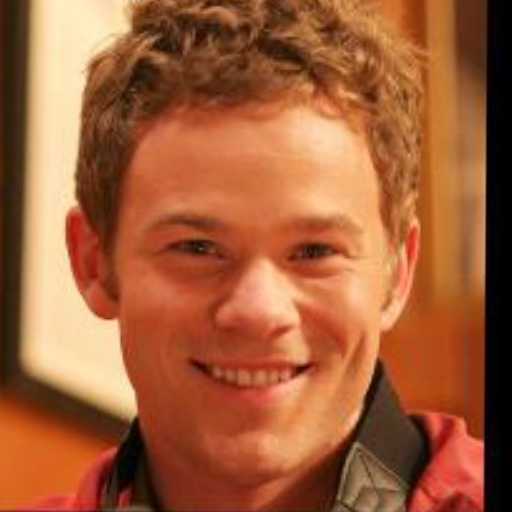

In [3]:
img_path = 'notebook/Aaron_Ashmore_adult_001.png'
Image.open(img_path)

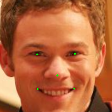

In [4]:
face_process(img_path, plot=True)

-----

In [2]:
mtlface = MTLFace().cuda().eval()
mtlface.load_state_dict(torch.load('mtlface_checkpoints.tar'))

<All keys matched successfully>

In [3]:
from PIL import Image
from torchvision import transforms
root = 'notebook'
images = []
for fname in ['071A42.JPG', '046A10.JPG']:
     path = osp.join(root, fname)
     input_img = Image.open(path).convert("RGB")
     transform = transforms.Compose([
          transforms.Resize(112),
          transforms.ToTensor(),
          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5], inplace=True)
     ])
     input_img = transform(input_img).unsqueeze(0)
     images.append(input_img.cuda())
images = torch.cat(images, dim=0)

In [4]:
x_vec, x_age = mtlface.encode(images)

# Face Recognition

In [5]:
(x_vec[0] * x_vec[1]).sum() # cosine similarity

tensor(0.0025, device='cuda:0')

# Age Estimation

In [6]:
x_age

tensor([47.0336, 15.0404], device='cuda:0')

# Face Age Synthesis

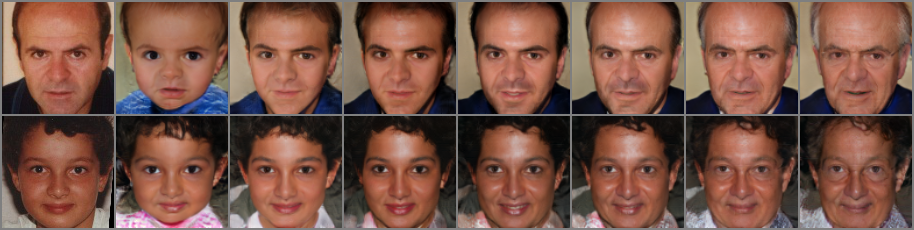

In [7]:
bs = images.size(0)
target_labels = torch.arange(7).cuda().unsqueeze(1).repeat(bs, 1).flatten()
repeat_images = images.unsqueeze(1).repeat(1, 7, 1, 1, 1).view(-1, 3, 112, 112)
outputs = mtlface.aging(repeat_images, target_labels).view(bs, 7, 3, 112, 112)
outputs = torch.cat([images.unsqueeze(1), outputs], dim=1).view(-1, 3, 112, 112)
to_pil_image(make_grid(outputs) * 0.5 + 0.5)